In [5]:
import pandas as pd

# Load the one-hot encoded dataset
df = pd.read_csv('../data/processed/modelling_file.csv')  # update path if different

# Show shape and first few rows
print(f"Shape: {df.shape}")
df.head()


Shape: (7032, 31)


,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,...,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn
0,0,1,29.85,29.85,False,True,False,False,True,False,...,False,False,False,False,False,True,False,True,False,0
1,0,34,56.95,1889.50,True,False,False,True,False,False,...,False,False,False,True,False,False,False,False,True,0
2,0,2,53.85,108.15,True,False,False,True,False,False,...,False,False,False,False,False,True,False,False,True,1
3,0,45,42.30,1840.75,True,False,False,False,True,False,...,False,False,False,True,False,False,False,False,False,0
4,0,2,70.70,151.65,False,False,False,True,False,False,...,False,False,False,False,False,True,False,True,False,1


### 🧪 Split the Data into Train and Test Sets

We will now split the one-hot encoded dataset into training and testing sets for model training and evaluation.


In [6]:
from sklearn.model_selection import train_test_split

# Separate features and target
X = df.drop('Churn', axis=1)
y = df['Churn']

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(f"Train shape: {X_train.shape}")
print(f"Test shape: {X_test.shape}")


Train shape: (5625, 30)
Test shape: (1407, 30)


### Model Training and Saving

We will train 5 different classifiers on the training data and evaluate them on the test set:
- Logistic Regression
- Random Forest
- XGBoost
- Gradient Boosting
- K-Nearest Neighbors

The best-performing model will be selected for deployment. Each model will be saved in the `models/` directory using `joblib`.


In [7]:
import os
import joblib
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

# Define models
models = {
    "logistic_regression": LogisticRegression(max_iter=1000),
    "random_forest": RandomForestClassifier(),
    "xgboost": XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "gradient_boosting": GradientBoostingClassifier(),
    "knn": KNeighborsClassifier()
}

# Output folder
os.makedirs("../models", exist_ok=True)

# Train and evaluate
for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, model.predict_proba(X_test)[:,1])

    print(f"{name}: Accuracy={acc:.4f}, F1-score={f1:.4f}, ROC-AUC={roc:.4f}")

    joblib.dump(model, f"../models/{name}.joblib")


C:\telco-churn-prediction\venv\lib\site-packages\sklearn\linear_model\_logistic.py:470: ConvergenceWarning: lbfgs failed to converge after 1000 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=1000).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


logistic_regression: Accuracy=0.7875, F1-score=0.5635, ROC-AUC=0.8321
random_forest: Accuracy=0.7903, F1-score=0.5455, ROC-AUC=0.8182


C:\telco-churn-prediction\venv\lib\site-packages\xgboost\training.py:183: UserWarning: [19:19:37] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


xgboost: Accuracy=0.7740, F1-score=0.5391, ROC-AUC=0.8108
gradient_boosting: Accuracy=0.7896, F1-score=0.5474, ROC-AUC=0.8338
knn: Accuracy=0.7711, F1-score=0.5121, ROC-AUC=0.7365


### ✅ Selected Model for Deployment: Gradient Boosting

Based on the evaluation metrics (Accuracy, F1 Score, and ROC-AUC), the **Gradient Boosting Classifier** was chosen for deployment. It showed the best overall balance between precision and recall with a high ROC-AUC score.

We will now proceed to build the final UI using this model to predict customer churn.


Top 15 important features:
                                  Feature  Importance
1                                 tenure    0.312437
10           InternetService_Fiber optic    0.207910
28        PaymentMethod_Electronic check    0.093471
3                           TotalCharges    0.077208
2                         MonthlyCharges    0.063540
25                     Contract_Two year    0.058727
24                     Contract_One year    0.057122
13                    OnlineSecurity_Yes    0.019909
19                       TechSupport_Yes    0.017439
26                  PaperlessBilling_Yes    0.013180
0                          SeniorCitizen    0.011810
23                   StreamingMovies_Yes    0.009943
16  DeviceProtection_No internet service    0.009129
20       StreamingTV_No internet service    0.007373
21                       StreamingTV_Yes    0.005938


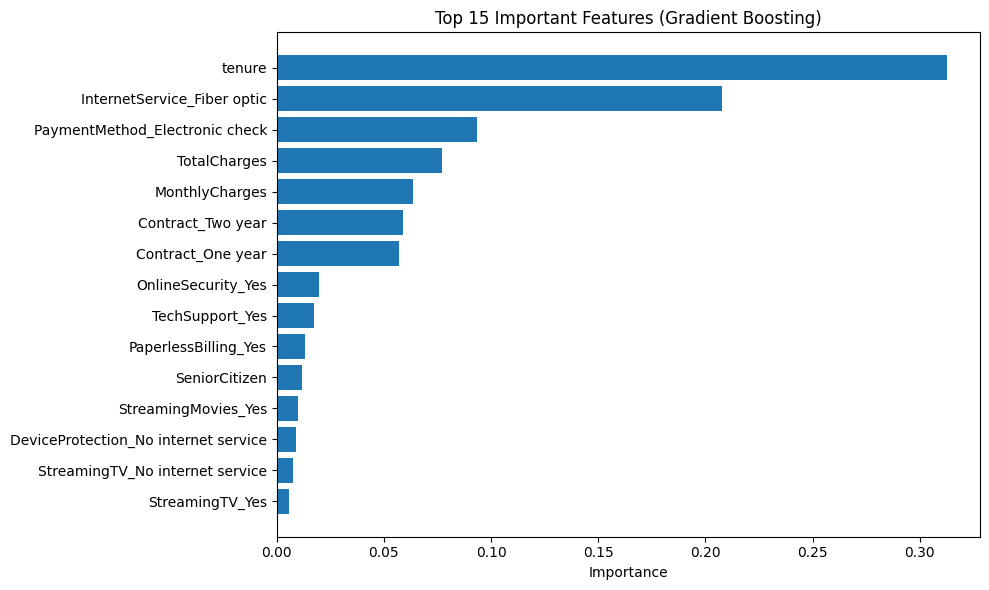

In [8]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load your trained model
model = joblib.load('../models/gradient_boosting.joblib')

# Assuming you have your training data columns saved or available
feature_names = X_train.columns  # use the same X_train used for training

# Get feature importances
importances = model.feature_importances_
importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Display top 15
print("Top 15 important features:\n", importance_df.head(15))

# Optional: visualize
plt.figure(figsize=(10,6))
plt.barh(importance_df.head(15)['Feature'], importance_df.head(15)['Importance'])
plt.gca().invert_yaxis()
plt.title('Top 15 Important Features (Gradient Boosting)')
plt.xlabel('Importance')
plt.tight_layout()
plt.show()


## Selected Features for User Input

Based on the model's feature importance analysis, we will use the following key features as inputs in our user interface to ensure accurate and efficient prediction:

- Senior Citizen (True / False)
- Tenure (months)
- Monthly Charges
- Total Charges
- Contract Type (month-to-month, one year, two year)
- Internet Service (DSL, Fiber optic, No)
- Payment Method (electronic check, mailed check, credit card (automatic))
- Online Security (True / False)
- Tech Support (True / False)
- Paperless Billing (True / False)
- Streaming Movies (True / False)
- Device Protection (True / False)
- Streaming TV (True / False)

This selection covers the most influential features impacting churn prediction, simplifying the UI while maintaining model performance.
